In [9]:
# split data into train and test sets
from numpy import unique
from numpy import nan
from numpy import array
from numpy import savetxt
from pandas import read_csv

# split the dataset by 'chunkID', return a dict of id to rows
def to_chunks(values, chunk_ix=1):
	chunks = dict()
	# get the unique chunk ids
	chunk_ids = unique(values[:, chunk_ix])
	# group rows by chunk id
	for chunk_id in chunk_ids:
		selection = values[:, chunk_ix] == chunk_id
		chunks[chunk_id] = values[selection, :]
	return chunks

# split each chunk into train/test sets
def split_train_test(chunks, row_in_chunk_ix=2):
	train, test = list(), list()
	# first 5 days of hourly observations for train
	cut_point = 5 * 24
	# enumerate chunks
	for k,rows in chunks.items():
		# split chunk rows by 'position_within_chunk'
		train_rows = rows[rows[:,row_in_chunk_ix] <= cut_point, :]
		test_rows = rows[rows[:,row_in_chunk_ix] > cut_point, :]
		if len(train_rows) == 0 or len(test_rows) == 0:
			print('>dropping chunk=%d: train=%s, test=%s' % (k, train_rows.shape, test_rows.shape))
			continue
		# store with chunk id, position in chunk, hour and all targets
		indices = [1,2,5] + [x for x in range(56,train_rows.shape[1])]
		train.append(train_rows[:, indices])
		test.append(test_rows[:, indices])
	return train, test

# return a list of relative forecast lead times
def get_lead_times():
	return [1, 2 ,3, 4, 5, 10, 17, 24, 48, 72]

# convert the rows in a test chunk to forecasts
def to_forecasts(test_chunks, row_in_chunk_ix=1):
	# get lead times
	lead_times = get_lead_times()
	# first 5 days of hourly observations for train
	cut_point = 5 * 24
	forecasts = list()
	# enumerate each chunk
	for rows in test_chunks:
		chunk_id = rows[0, 0]
		# enumerate each lead time
		for tau in lead_times:
			# determine the row in chunk we want for the lead time
			offset = cut_point + tau
			# retrieve data for the lead time using row number in chunk
			row_for_tau = rows[rows[:,row_in_chunk_ix]==offset, :]
			# check if we have data
			if len(row_for_tau) == 0:
				# create a mock row [chunk, position, hour] + [nan...]
				row = [chunk_id, offset, nan] + [nan for _ in range(39)]
				forecasts.append(row)
			else:
				# store the forecast row
				forecasts.append(row_for_tau[0])
	return array(forecasts)

# load dataset
dataset = read_csv('TrainingData.csv', header=0)

In [19]:
dataset

,rowID,chunkID,position_within_chunk,month_most_common,weekday,hour,Solar.radiation_64,WindDirection..Resultant_1,WindDirection..Resultant_1018,WindSpeed..Resultant_1,...,target_4_6006,target_4_8003,target_5_6006,target_7_57,target_8_57,target_8_4002,target_8_6004,target_8_8003,target_9_4002,target_9_8003
0,1,1,1,10,Saturday,21,0.01,117.0,187.0,0.3,...,1.748424,NaN,NaN,5.130631,1.341606,2.138792,3.013752,NaN,5.679280,NaN
1,2,1,2,10,Saturday,22,0.01,231.0,202.0,0.5,...,2.144120,NaN,NaN,5.130631,1.195779,2.722099,3.888712,NaN,7.426751,NaN
2,3,1,3,10,Saturday,23,0.01,247.0,227.0,0.5,...,1.932469,NaN,NaN,5.136395,1.409658,3.110970,3.888712,NaN,7.683732,NaN
3,4,1,4,10,Sunday,0,0.01,219.0,218.0,0.2,...,2.088907,NaN,NaN,5.217102,1.477711,2.041574,3.208188,NaN,4.831243,NaN
4,5,1,5,10,Sunday,1,0.01,2.0,216.0,0.2,...,2.604232,NaN,NaN,5.217102,1.458267,2.138792,3.499841,NaN,4.625658,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37816,55364,210,188,8,Wednesday,4,0.01,35.0,NaN,0.5,...,1.453953,NaN,0.933143,NaN,NaN,0.291653,0.291653,NaN,0.642453,NaN
37817,55365,210,189,8,Wednesday,5,0.01,41.0,NaN,0.5,...,1.076661,NaN,0.599878,NaN,NaN,0.291653,0.291653,NaN,1.002226,NaN
37818,55366,210,190,8,Wednesday,6,0.04,90.0,NaN,1.6,...,1.113470,NaN,0.599878,NaN,NaN,0.291653,0.291653,NaN,0.822339,NaN
37819,55367,210,191,8,Wednesday,7,0.14,35.0,NaN,0.8,...,1.058257,NaN,0.666531,NaN,NaN,0.291653,0.291653,NaN,0.719547,NaN


In [10]:
# group data by chunks
values = dataset.values
chunks = to_chunks(values)
# split into train/test
train, test = split_train_test(chunks)

>dropping chunk=69: train=(0, 95), test=(28, 95)


In [24]:
chunks[1].shape

(192, 95)

In [13]:
len(train), train[0].shape, len(test), test[0].shape

(207, (120, 42), 207, (72, 42))

In [14]:
# flatten training chunks to rows
train_rows = array([row for rows in train for row in rows])
# print(train_rows.shape)
print('Train Rows: %s' % str(train_rows.shape))
# reduce train to forecast lead times only
test_rows = to_forecasts(test)
print('Test Rows: %s' % str(test_rows.shape))
# save datasets
savetxt('naive_train.csv', train_rows, delimiter=',')
savetxt('naive_test.csv', test_rows, delimiter=',')

Train Rows: (23514, 42)
Test Rows: (2070, 42)


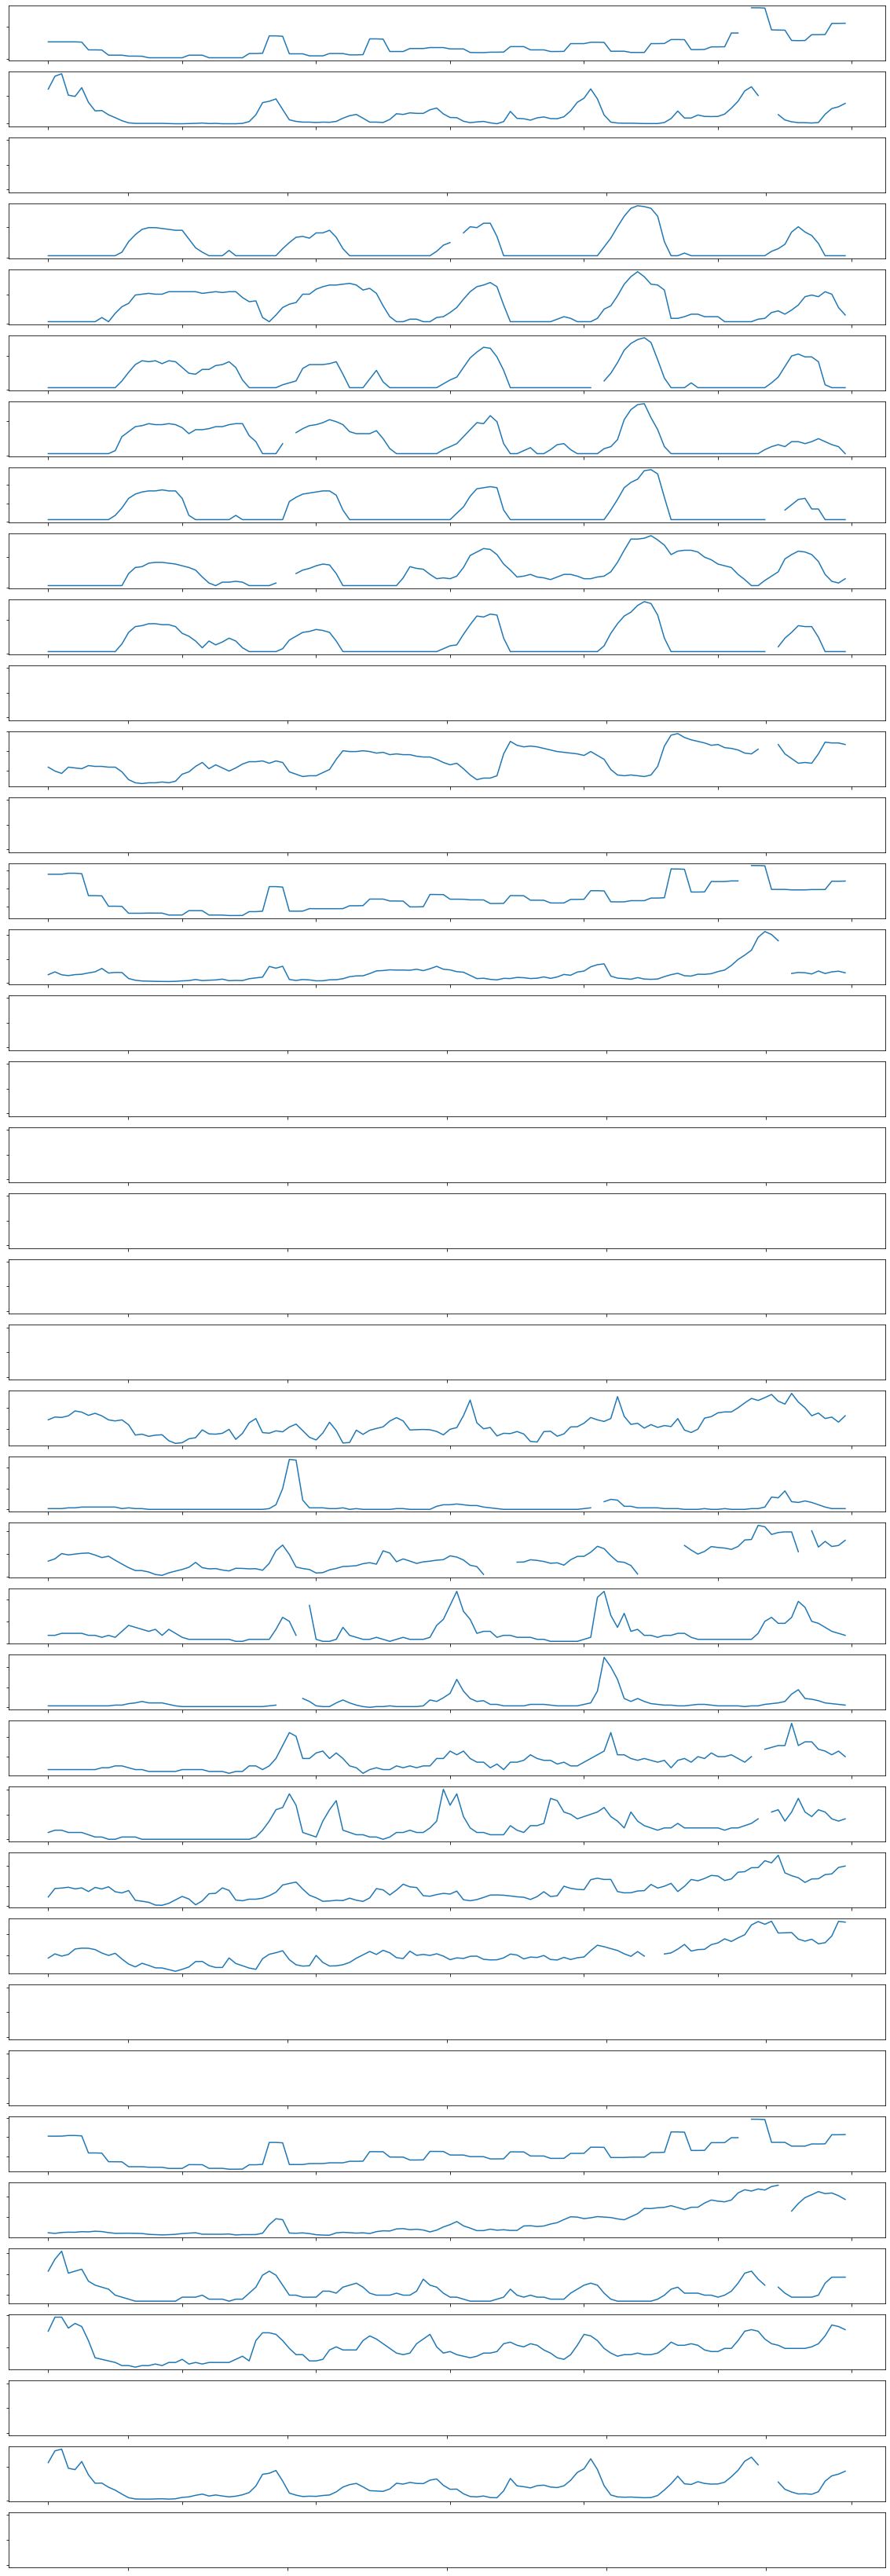

In [27]:
# plot missing
from numpy import loadtxt
from numpy import nan
from numpy import unique
from matplotlib import pyplot
 
# split the dataset by 'chunkID', return a list of chunks
def to_chunks(values, chunk_ix=0):
	chunks = list()
	# get the unique chunk ids
	chunk_ids = unique(values[:, chunk_ix])
	# group rows by chunk id
	for chunk_id in chunk_ids:
		selection = values[:, chunk_ix] == chunk_id
		chunks.append(values[selection, :])
	return chunks
 
# layout a variable with breaks in the data for missing positions
def variable_to_series(chunk_train, col_ix, n_steps=5*24):
	# lay out whole series
	data = [nan for _ in range(n_steps)]
	# mark all available data
	for i in range(len(chunk_train)):
		# get position in chunk
		position = int(chunk_train[i, 1] - 1)
		# store data
		data[position] = chunk_train[i, col_ix]
	return data
 
# plot variables horizontally with gaps for missing data
def plot_variables(chunk_train, n_vars=39):
	pyplot.figure(figsize=(20, 60))
	for i in range(n_vars):
		# convert target number into column number
		col_ix = 3 + i
		# mark missing obs for variable
		series = variable_to_series(chunk_train, col_ix)
		# plot
		ax = pyplot.subplot(n_vars, 1, i+1)
		ax.set_xticklabels([])
		ax.set_yticklabels([])
		pyplot.plot(series)
	# show plot
	pyplot.show()
 
# load dataset
train = loadtxt('naive_train.csv', delimiter=',')
# group data by chunks
train_chunks = to_chunks(train)
# pick one chunk
rows = train_chunks[0]
# plot variables
plot_variables(rows)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


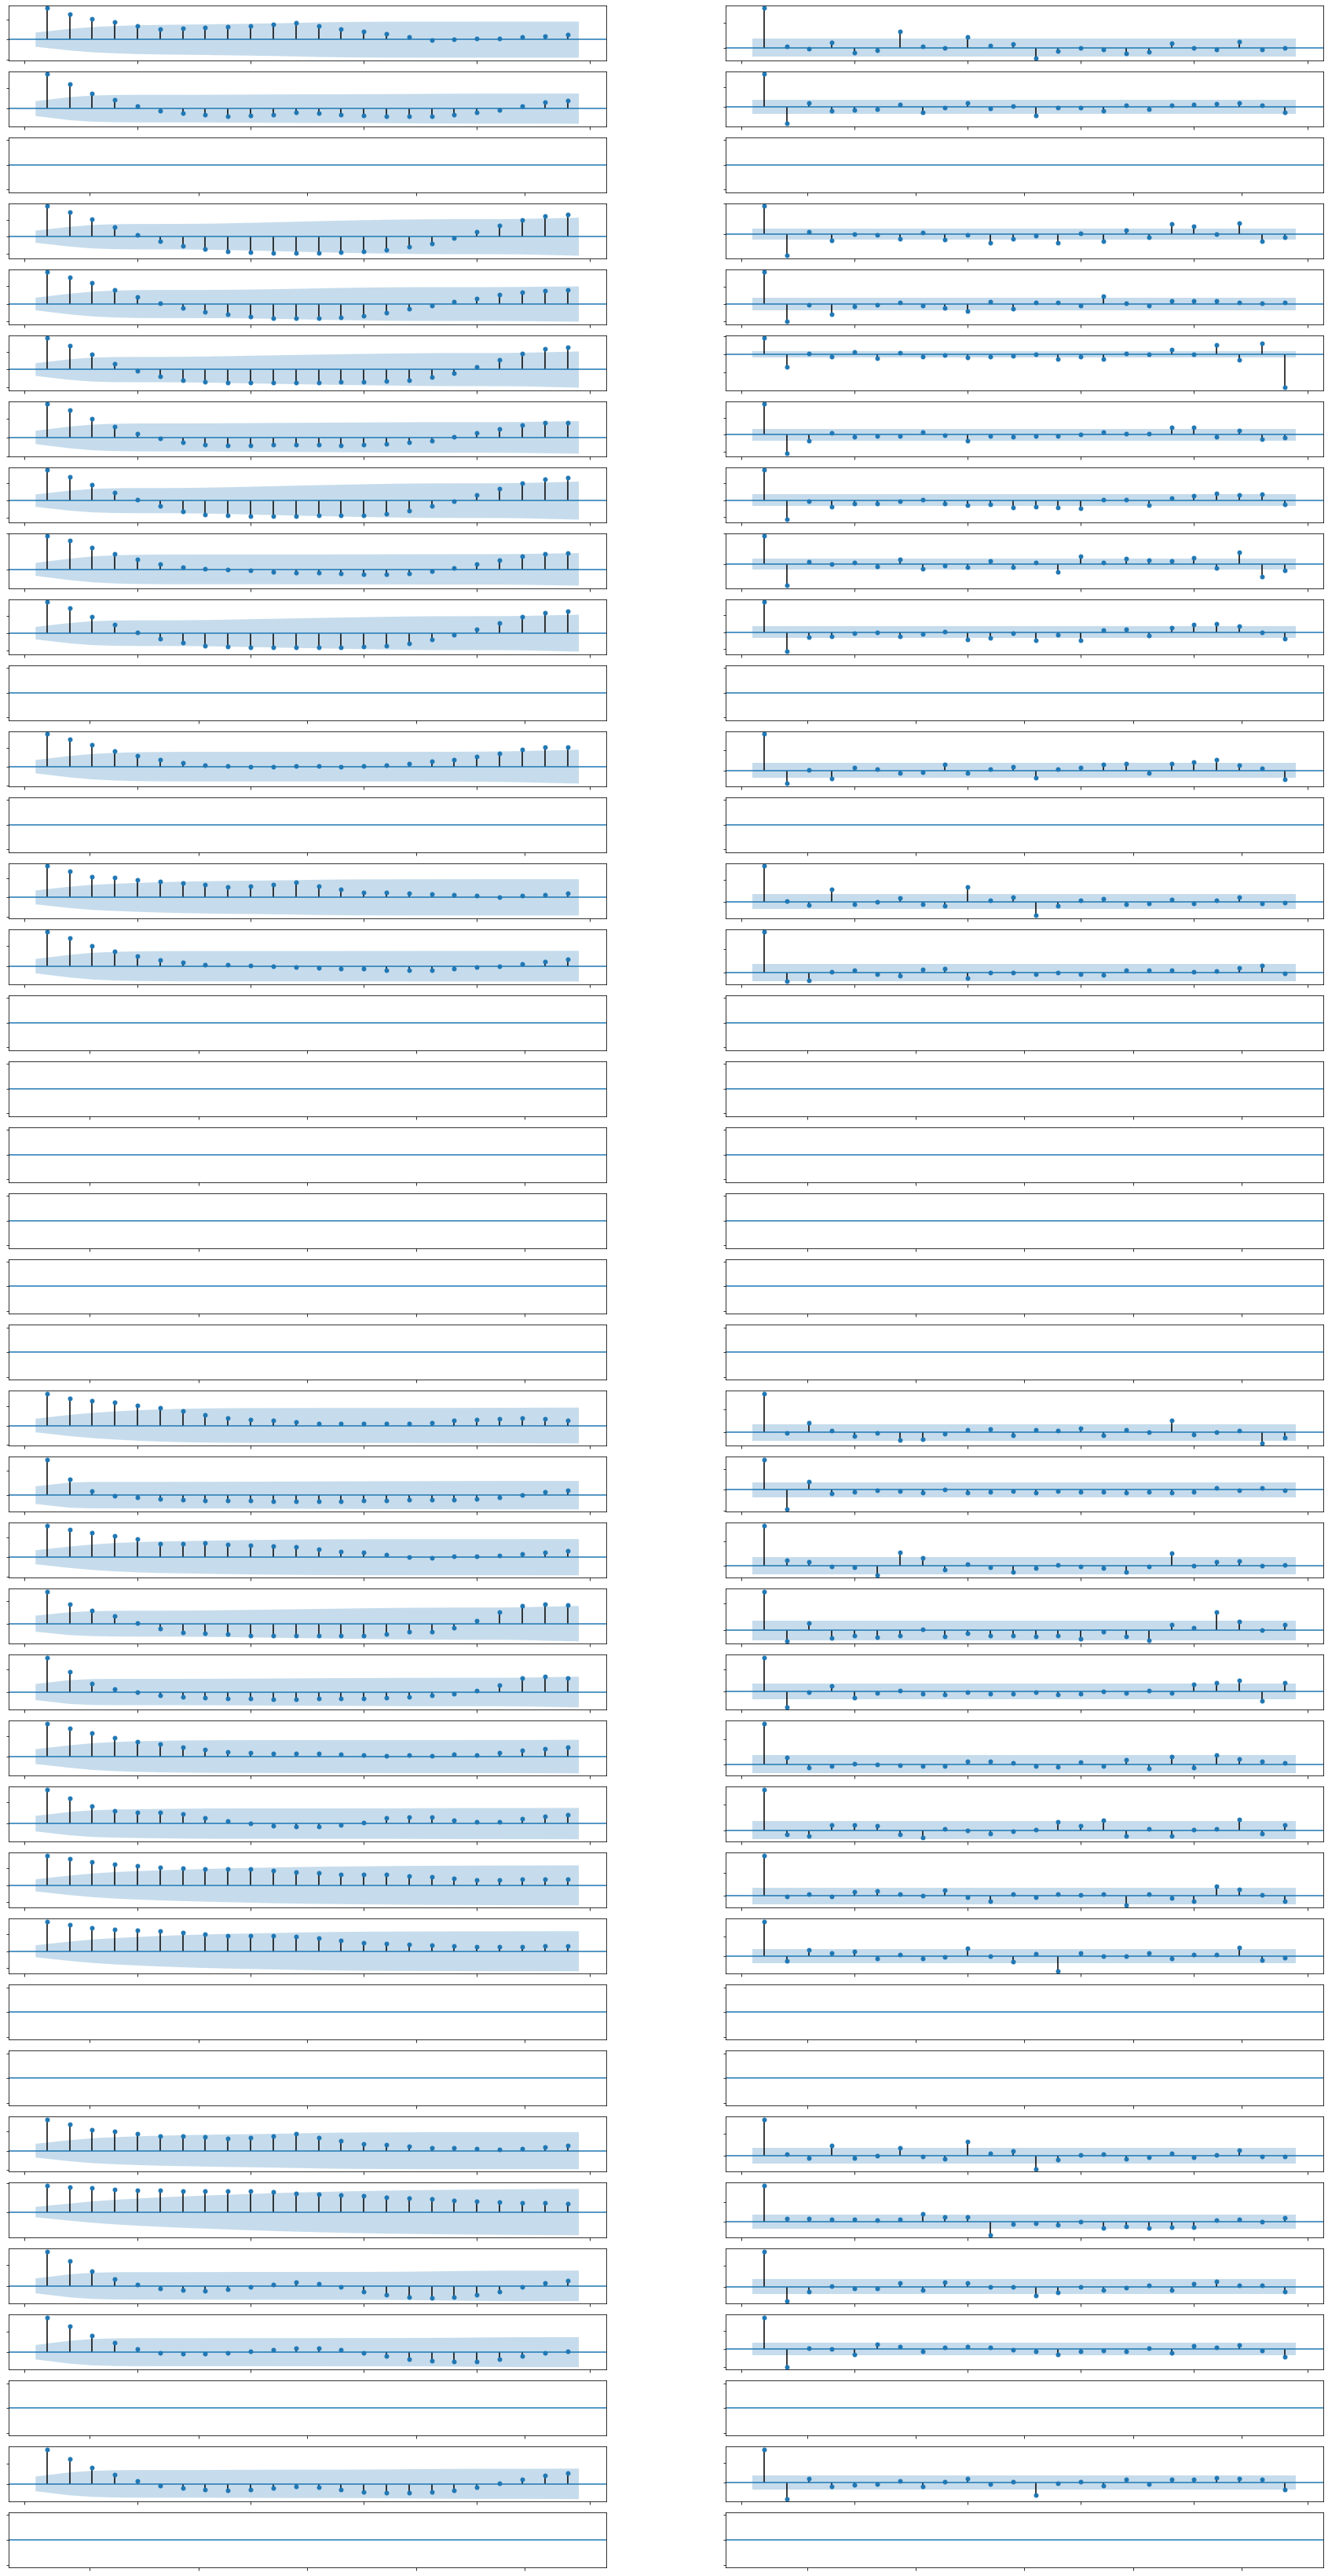

In [30]:
# acf and pacf plots
from numpy import loadtxt
from numpy import nan
from numpy import isnan
from numpy import count_nonzero
from numpy import unique
from numpy import nanmedian
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# split the dataset by 'chunkID', return a list of chunks
def to_chunks(values, chunk_ix=0):
	chunks = list()
	# get the unique chunk ids
	chunk_ids = unique(values[:, chunk_ix])
	# group rows by chunk id
	for chunk_id in chunk_ids:
		selection = values[:, chunk_ix] == chunk_id
		chunks.append(values[selection, :])
	return chunks

# impute missing data
def impute_missing(rows, hours, series, col_ix):
	# count missing observations
	n_missing = count_nonzero(isnan(series))
	# calculate ratio of missing
	ratio = n_missing / float(len(series)) * 100
	# check for no data
	if ratio == 100.0:
		return series
	# impute missing using the median value for hour in the series
	imputed = list()
	for i in range(len(series)):
		if isnan(series[i]):
			# get all rows with the same hour
			matches = rows[rows[:,2]==hours[i]]
			# fill with median value
			value = nanmedian(matches[:, col_ix])
			imputed.append(value)
		else:
			imputed.append(series[i])
	return imputed

# interpolate series of hours (in place) in 24 hour time
def interpolate_hours(hours):
	# find the first hour
	ix = -1
	for i in range(len(hours)):
		if not isnan(hours[i]):
			ix = i
			break
	# fill-forward
	hour = hours[ix]
	for i in range(ix+1, len(hours)):
		# increment hour
		hour += 1
		# check for a fill
		if isnan(hours[i]):
			hours[i] = hour % 24
	# fill-backward
	hour = hours[ix]
	for i in range(ix-1, -1, -1):
		# decrement hour
		hour -= 1
		# check for a fill
		if isnan(hours[i]):
			hours[i] = hour % 24

# layout a variable with breaks in the data for missing positions
def variable_to_series(chunk_train, col_ix, n_steps=5*24):
	# lay out whole series
	data = [nan for _ in range(n_steps)]
	# mark all available data
	for i in range(len(chunk_train)):
		# get position in chunk
		position = int(chunk_train[i, 1] - 1)
		# store data
		data[position] = chunk_train[i, col_ix]
	return data

# plot acf and pacf plots for each imputed variable series
def plot_variables(chunk_train, hours, n_vars=39):
	pyplot.figure(figsize=(30,60))
	n_plots = n_vars * 2
	j = 0
	lags = 24
	for i in range(1, n_plots, 2):
		# convert target number into column number
		col_ix = 3 + j
		j += 1
		# get series
		series = variable_to_series(chunk_train, col_ix)
		imputed = impute_missing(chunk_train, hours, series, col_ix)
		# acf
		axis = pyplot.subplot(n_vars, 2, i)
		plot_acf(imputed, ax=axis, lags=lags, zero=False)
		axis.set_title('')
		axis.set_xticklabels([])
		axis.set_yticklabels([])
		# pacf
		axis = pyplot.subplot(n_vars, 2, i+1)
		plot_pacf(imputed, ax=axis, lags=lags, zero=False)
		axis.set_title('')
		axis.set_xticklabels([])
		axis.set_yticklabels([])
	# show plot
	pyplot.show()

# load dataset
train = loadtxt('naive_train.csv', delimiter=',')
# group data by chunks
train_chunks = to_chunks(train)
# pick one chunk
rows = train_chunks[0]
# prepare sequence of hours for the chunk
hours = variable_to_series(rows, 2)
# interpolate hours
interpolate_hours(hours)
# plot variables
plot_variables(rows, hours)

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarnin

AR: [0.492 MAE] +1 0.225, +2 0.341, +3 0.410, +4 0.475, +5 0.512, +10 0.593, +17 0.586, +24 0.588, +48 0.588, +72 0.604


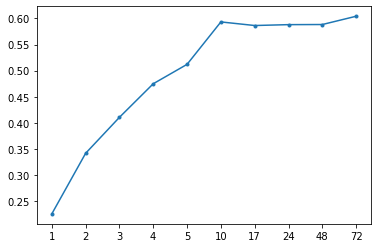

In [31]:
# autoregression forecast
from numpy import loadtxt
from numpy import nan
from numpy import isnan
from numpy import count_nonzero
from numpy import unique
from numpy import array
from numpy import nanmedian
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
from warnings import catch_warnings
from warnings import filterwarnings

# split the dataset by 'chunkID', return a list of chunks
def to_chunks(values, chunk_ix=0):
	chunks = list()
	# get the unique chunk ids
	chunk_ids = unique(values[:, chunk_ix])
	# group rows by chunk id
	for chunk_id in chunk_ids:
		selection = values[:, chunk_ix] == chunk_id
		chunks.append(values[selection, :])
	return chunks

# return a list of relative forecast lead times
def get_lead_times():
	return [1, 2, 3, 4, 5, 10, 17, 24, 48, 72]

# interpolate series of hours (in place) in 24 hour time
def interpolate_hours(hours):
	# find the first hour
	ix = -1
	for i in range(len(hours)):
		if not isnan(hours[i]):
			ix = i
			break
	# fill-forward
	hour = hours[ix]
	for i in range(ix+1, len(hours)):
		# increment hour
		hour += 1
		# check for a fill
		if isnan(hours[i]):
			hours[i] = hour % 24
	# fill-backward
	hour = hours[ix]
	for i in range(ix-1, -1, -1):
		# decrement hour
		hour -= 1
		# check for a fill
		if isnan(hours[i]):
			hours[i] = hour % 24

# return true if the array has any non-nan values
def has_data(data):
	return count_nonzero(isnan(data)) < len(data)

# impute missing data
def impute_missing(rows, hours, series, col_ix):
	# impute missing using the median value for hour in the series
	imputed = list()
	for i in range(len(series)):
		if isnan(series[i]):
			# get all rows with the same hour
			matches = rows[rows[:,2]==hours[i]]
			# fill with median value
			value = nanmedian(matches[:, col_ix])
			if isnan(value):
				value = 0.0
			imputed.append(value)
		else:
			imputed.append(series[i])
	return imputed

# layout a variable with breaks in the data for missing positions
def variable_to_series(chunk_train, col_ix, n_steps=5*24):
	# lay out whole series
	data = [nan for _ in range(n_steps)]
	# mark all available data
	for i in range(len(chunk_train)):
		# get position in chunk
		position = int(chunk_train[i, 1] - 1)
		# store data
		data[position] = chunk_train[i, col_ix]
	return data

# fit AR model and generate a forecast
def fit_and_forecast(series):
	# define the model
	model = ARIMA(series, order=(1,0,0))
	# return a nan forecast in case of exception
	try:
		# ignore statsmodels warnings
		with catch_warnings():
			filterwarnings("ignore")
			# fit the model
			model_fit = model.fit()
			# forecast 72 hours
			yhat = model_fit.predict(len(series), len(series)+72)
			# extract lead times
			lead_times = array(get_lead_times())
			indices = lead_times - 1
			return yhat[indices]
	except:
		return [nan for _ in range(len(get_lead_times()))]

# forecast all lead times for one variable
def forecast_variable(hours, chunk_train, chunk_test, lead_times, target_ix):
	# convert target number into column number
	col_ix = 3 + target_ix
	# check for no data
	if not has_data(chunk_train[:, col_ix]):
		forecast = [nan for _ in range(len(lead_times))]
		return forecast
	# get series
	series = variable_to_series(chunk_train, col_ix)
	# impute
	imputed = impute_missing(chunk_train, hours, series, col_ix)
	# fit AR model and forecast
	forecast = fit_and_forecast(imputed)
	return forecast

# forecast for each chunk, returns [chunk][variable][time]
def forecast_chunks(train_chunks, test_input):
	lead_times = get_lead_times()
	predictions = list()
	# enumerate chunks to forecast
	for i in range(len(train_chunks)):
		# prepare sequence of hours for the chunk
		hours = variable_to_series(train_chunks[i], 2)
		# interpolate hours
		interpolate_hours(hours)
		# enumerate targets for chunk
		chunk_predictions = list()
		for j in range(39):
			yhat = forecast_variable(hours, train_chunks[i], test_input[i], lead_times, j)
			chunk_predictions.append(yhat)
		chunk_predictions = array(chunk_predictions)
		predictions.append(chunk_predictions)
	return array(predictions)

# convert the test dataset in chunks to [chunk][variable][time] format
def prepare_test_forecasts(test_chunks):
	predictions = list()
	# enumerate chunks to forecast
	for rows in test_chunks:
		# enumerate targets for chunk
		chunk_predictions = list()
		for j in range(3, rows.shape[1]):
			yhat = rows[:, j]
			chunk_predictions.append(yhat)
		chunk_predictions = array(chunk_predictions)
		predictions.append(chunk_predictions)
	return array(predictions)

# calculate the error between an actual and predicted value
def calculate_error(actual, predicted):
	# give the full actual value if predicted is nan
	if isnan(predicted):
		return abs(actual)
	# calculate abs difference
	return abs(actual - predicted)

# evaluate a forecast in the format [chunk][variable][time]
def evaluate_forecasts(predictions, testset):
	lead_times = get_lead_times()
	total_mae, times_mae = 0.0, [0.0 for _ in range(len(lead_times))]
	total_c, times_c = 0, [0 for _ in range(len(lead_times))]
	# enumerate test chunks
	for i in range(len(test_chunks)):
		# convert to forecasts
		actual = testset[i]
		predicted = predictions[i]
		# enumerate target variables
		for j in range(predicted.shape[0]):
			# enumerate lead times
			for k in range(len(lead_times)):
				# skip if actual in nan
				if isnan(actual[j, k]):
					continue
				# calculate error
				error = calculate_error(actual[j, k], predicted[j, k])
				# update statistics
				total_mae += error
				times_mae[k] += error
				total_c += 1
				times_c[k] += 1
	# normalize summed absolute errors
	total_mae /= total_c
	times_mae = [times_mae[i]/times_c[i] for i in range(len(times_mae))]
	return total_mae, times_mae

# summarize scores
def summarize_error(name, total_mae, times_mae):
	# print summary
	lead_times = get_lead_times()
	formatted = ['+%d %.3f' % (lead_times[i], times_mae[i]) for i in range(len(lead_times))]
	s_scores = ', '.join(formatted)
	print('%s: [%.3f MAE] %s' % (name, total_mae, s_scores))
	# plot summary
	pyplot.plot([str(x) for x in lead_times], times_mae, marker='.')
	pyplot.show()

# load dataset
train = loadtxt('naive_train.csv', delimiter=',')
test = loadtxt('naive_test.csv', delimiter=',')
# group data by chunks
train_chunks = to_chunks(train)
test_chunks = to_chunks(test)
# forecast
test_input = [rows[:, :3] for rows in test_chunks]
forecast = forecast_chunks(train_chunks, test_input)
# evaluate forecast
actual = prepare_test_forecasts(test_chunks)
total_mae, times_mae = evaluate_forecasts(forecast, actual)
# summarize forecast
summarize_error('AR', total_mae, times_mae)